In [1]:
from load_data import MyOwnDataset
import torch
import torch.nn as nn
from torch.nn import Linear, ConvTranspose2d, MSELoss,CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GAE
from torch_geometric.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
import os
import numpy as np


print("Loading data....")
dataset = MyOwnDataset(root = "forces_data/")
train_dataset = dataset[:4500]
test_dataset = dataset[4500:5000]
image_train_dataset = []
image_test_dataset = []
for i in range (4500):
    image = cv2.imread('binary_FE/mesh_%d.png'%i)
    image = torch.tensor(image)
    image = image[:,:,1]/float(255)
    image = image.type(torch.float32)
    
#     print("%d/4500" %i)
    image_train_dataset.append(image)
for i in range (4500,5000):
    image = cv2.imread('binary_FE/mesh_%d.png'%i)
    image = torch.tensor(image)
    image = image[:,:,1]/float(255)
    image = image.type(torch.float32)
#     print("%d/500" %(i-4500))
    image_test_dataset.append(image)
        
torch.set_printoptions(edgeitems=1000)
print(image_train_dataset[1])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_images_loader = torch.utils.data.DataLoader(
    image_train_dataset, batch_size = 64
    )
test_images_loader = torch.utils.data.DataLoader(
    image_test_dataset, batch_size = 64
    )
print(f'Number of training batches created: {len(train_loader)}')
print()


Loading data....
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.

In [2]:
print("Training dataset length: ", len(train_dataset), "\nTesting dataset length: ", len(test_dataset))
print("Training images loaded:", len(image_train_dataset), "\nTesting images loaded:", len(image_test_dataset))
print()


Training dataset length:  4500 
Testing dataset length:  500
Training images loaded: 4500 
Testing images loaded: 500



In [4]:
data = dataset[0]
print("Node attributes of the graph (coordinates, fixation and forces applied)")
print(data.x)
print()
print("Edge indices:")
print(data.edge_index)
print()
print("Class of the graph:")
print(data.y)

Node attributes of the graph (coordinates, fixation and forces applied)
tensor([[ 0.2809, -0.2675,  0.0000,  0.0000,  4.1400,  4.9600],
        [ 0.7289,  0.5147,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3872,  0.8040,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.8861,  0.1053,  1.0000,  0.0000,  0.0000,  0.0000],
        [-0.4807, -0.7518,  1.0000,  1.0000,  0.0000,  0.0000]])

Edge indices:
tensor([[0, 0, 1, 1, 2, 2, 3, 3, 4, 4],
        [4, 1, 0, 2, 1, 3, 2, 4, 0, 3]])

Class of the graph:
tensor([0])


In [3]:
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 40, 6, 6)

# class ReOrder(nn.Module):
#     def forward(self, input):
#         return input.view(input.size(0), input.size(2),input.size(3),input.size(1))

class Encoder(torch.nn.Module):
    def __init__(self,hidden_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 32)
        self.conv3 = GCNConv(32, 64)
        self.lin1 = Linear(64, 128)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        x = F.relu(x)


        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.up = nn.Sequential(
            nn.Linear(128, 256, bias = True),
            nn.ReLU(True),
            nn.Linear(256, 512, bias = True),
            nn.ReLU(True),
            nn.Linear(512, 1440, bias = True),
            nn.ReLU(True),
            UnFlatten(),
            nn.ConvTranspose2d(40,40,kernel_size=(4,4),stride = (3,3), bias = True),
            nn.ReLU(True),
            nn.ConvTranspose2d(40,20,kernel_size = (4,4), stride = (4,4), padding = 1, bias = True),
            nn.ReLU(True),
            nn.ConvTranspose2d(20,1,kernel_size = (4,4), stride = (2,2),  bias = True),
            )
    def forward(self, output):
        res = self.up(output)
        res = res.squeeze()
        return res

print("Printing Encoder/Decoder Model:")
model = GAE(Encoder(hidden_channels=32), Decoder())
print(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = MSELoss()


Printing Encoder/Decoder Model:
GAE(
  (encoder): Encoder(
    (conv1): GCNConv(6, 32)
    (conv2): GCNConv(32, 32)
    (conv3): GCNConv(32, 64)
    (lin1): Linear(in_features=64, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (up): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=512, out_features=1440, bias=True)
      (5): ReLU(inplace=True)
      (6): UnFlatten()
      (7): ConvTranspose2d(40, 40, kernel_size=(4, 4), stride=(3, 3))
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(40, 20, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
      (10): ReLU(inplace=True)
      (11): ConvTranspose2d(20, 1, kernel_size=(4, 4), stride=(2, 2))
    )
  )
)


In [31]:
def train():
    model.train()
    for data, image in zip(train_loader, train_images_loader):
        encoded = model.encode(data.x, data.edge_index, data.batch)
        # print(encoded.size())
        out = model.decode(encoded)
#         print("OUT",out.size())
#         print("IMAGE",image.size())
        loss = criterion(out, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

def test():
    model.eval()

    for data, image in zip(test_loader, test_images_loader):
        encoded = model.encode(data.x, data.edge_index, data.batch)
        out = model.decode(encoded)
        test_loss = criterion(out, image)

    return test_loss

train_loss = []
test_loss = []


for epoch in range(1, 1050):
    loss = 0
    loss=train()
    testloss = test()
    train_loss.append(loss)
    test_loss.append(testloss)

    print(f'Epoch: {epoch:03d}, Train loss: {loss}, Test loss: {testloss}')

Epoch: 001, Train loss: 0.003131407080218196, Test loss: 0.009859176352620125
Epoch: 002, Train loss: 0.0021491649094969034, Test loss: 0.009580232203006744
Epoch: 003, Train loss: 0.0029547906015068293, Test loss: 0.00975925661623478
Epoch: 004, Train loss: 0.002518812660127878, Test loss: 0.009701650589704514
Epoch: 005, Train loss: 0.0023863944225013256, Test loss: 0.009728828445076942
Epoch: 006, Train loss: 0.0025294998195022345, Test loss: 0.0099019231274724
Epoch: 007, Train loss: 0.0022243401035666466, Test loss: 0.009815029799938202
Epoch: 008, Train loss: 0.0024313710164278746, Test loss: 0.01008931640535593
Epoch: 009, Train loss: 0.0024966364726424217, Test loss: 0.00970091950148344
Epoch: 010, Train loss: 0.002968792337924242, Test loss: 0.00985555350780487
Epoch: 011, Train loss: 0.0023111961781978607, Test loss: 0.009906782768666744
Epoch: 012, Train loss: 0.0024121529422700405, Test loss: 0.009831755422055721
Epoch: 013, Train loss: 0.0025330621283501387, Test loss: 0.0

Epoch: 106, Train loss: 0.002094961004331708, Test loss: 0.009706893935799599
Epoch: 107, Train loss: 0.002899797633290291, Test loss: 0.009510227479040623
Epoch: 108, Train loss: 0.0025739853736013174, Test loss: 0.009568460285663605
Epoch: 109, Train loss: 0.002338445745408535, Test loss: 0.009628165513277054
Epoch: 110, Train loss: 0.0024895493406802416, Test loss: 0.009449812583625317
Epoch: 111, Train loss: 0.00266313087195158, Test loss: 0.00953057873994112
Epoch: 112, Train loss: 0.0023397086188197136, Test loss: 0.009712966158986092
Epoch: 113, Train loss: 0.0027061528526246548, Test loss: 0.009602325968444347
Epoch: 114, Train loss: 0.0022134087048470974, Test loss: 0.009704493917524815
Epoch: 115, Train loss: 0.002543087350204587, Test loss: 0.009710553102195263
Epoch: 116, Train loss: 0.002345247194170952, Test loss: 0.009795473888516426
Epoch: 117, Train loss: 0.0020907288417220116, Test loss: 0.009402761235833168
Epoch: 118, Train loss: 0.00208034529350698, Test loss: 0.00

Epoch: 211, Train loss: 0.0022828299552202225, Test loss: 0.009105687960982323
Epoch: 212, Train loss: 0.0023104329593479633, Test loss: 0.009484784677624702
Epoch: 213, Train loss: 0.0030836898367851973, Test loss: 0.009039067663252354
Epoch: 214, Train loss: 0.0021690898574888706, Test loss: 0.009361029602587223
Epoch: 215, Train loss: 0.002694617258384824, Test loss: 0.0095956576988101
Epoch: 216, Train loss: 0.002658600453287363, Test loss: 0.009322370402514935
Epoch: 217, Train loss: 0.0024593460839241743, Test loss: 0.009357850067317486
Epoch: 218, Train loss: 0.0021704609971493483, Test loss: 0.009415633045136929
Epoch: 219, Train loss: 0.0030088576022535563, Test loss: 0.00970432348549366
Epoch: 220, Train loss: 0.002432271372526884, Test loss: 0.00927159283310175
Epoch: 221, Train loss: 0.002656499855220318, Test loss: 0.009615419432520866
Epoch: 222, Train loss: 0.002863636938855052, Test loss: 0.009595888666808605
Epoch: 223, Train loss: 0.0028087752871215343, Test loss: 0.0

Epoch: 316, Train loss: 0.0018888565246015787, Test loss: 0.010245291516184807
Epoch: 317, Train loss: 0.002580358413979411, Test loss: 0.010136584751307964
Epoch: 318, Train loss: 0.0030373826157301664, Test loss: 0.010414481163024902
Epoch: 319, Train loss: 0.0030570589005947113, Test loss: 0.01030511874705553
Epoch: 320, Train loss: 0.0019872335251420736, Test loss: 0.010383912362158298
Epoch: 321, Train loss: 0.0019014416029676795, Test loss: 0.010080148465931416
Epoch: 322, Train loss: 0.002357007469981909, Test loss: 0.010217325761914253
Epoch: 323, Train loss: 0.0020035027991980314, Test loss: 0.010192547924816608
Epoch: 324, Train loss: 0.0019620023667812347, Test loss: 0.009908073581755161
Epoch: 325, Train loss: 0.0022145328111946583, Test loss: 0.010114366188645363
Epoch: 326, Train loss: 0.0025717851240187883, Test loss: 0.009919937700033188
Epoch: 327, Train loss: 0.0026162052527070045, Test loss: 0.010109605267643929
Epoch: 328, Train loss: 0.002165451878681779, Test loss

Epoch: 421, Train loss: 0.0028389154467731714, Test loss: 0.009345907717943192
Epoch: 422, Train loss: 0.002595150377601385, Test loss: 0.00931580737233162
Epoch: 423, Train loss: 0.0021751117892563343, Test loss: 0.009306824766099453
Epoch: 424, Train loss: 0.0024371773470193148, Test loss: 0.009303256869316101
Epoch: 425, Train loss: 0.002897712867707014, Test loss: 0.009267459623515606
Epoch: 426, Train loss: 0.0025042921770364046, Test loss: 0.009497448801994324
Epoch: 427, Train loss: 0.002036056248471141, Test loss: 0.009595399722456932
Epoch: 428, Train loss: 0.0025380512233823538, Test loss: 0.009349843487143517
Epoch: 429, Train loss: 0.0023263641633093357, Test loss: 0.00941555481404066
Epoch: 430, Train loss: 0.002705611987039447, Test loss: 0.009619810618460178
Epoch: 431, Train loss: 0.0024086988996714354, Test loss: 0.009329167194664478
Epoch: 432, Train loss: 0.0023856554180383682, Test loss: 0.009227721020579338
Epoch: 433, Train loss: 0.0021973687689751387, Test loss: 

Epoch: 526, Train loss: 0.0023611329961568117, Test loss: 0.009886951185762882
Epoch: 527, Train loss: 0.0019293481018394232, Test loss: 0.009637769311666489
Epoch: 528, Train loss: 0.003101027337834239, Test loss: 0.00962669774889946
Epoch: 529, Train loss: 0.002662401180714369, Test loss: 0.009824266657233238
Epoch: 530, Train loss: 0.0019211858743801713, Test loss: 0.009913346730172634
Epoch: 531, Train loss: 0.0018687606789171696, Test loss: 0.009797241538763046
Epoch: 532, Train loss: 0.001899490598589182, Test loss: 0.009764558635652065
Epoch: 533, Train loss: 0.0020426756236702204, Test loss: 0.009831232018768787
Epoch: 534, Train loss: 0.0018667945405468345, Test loss: 0.009695521555840969
Epoch: 535, Train loss: 0.0017442702082917094, Test loss: 0.009676290675997734
Epoch: 536, Train loss: 0.0020490146707743406, Test loss: 0.009810847230255604
Epoch: 537, Train loss: 0.0019268442410975695, Test loss: 0.009902425110340118
Epoch: 538, Train loss: 0.002035961952060461, Test loss:

Epoch: 631, Train loss: 0.0020702825859189034, Test loss: 0.009908664971590042
Epoch: 632, Train loss: 0.0017727988306432962, Test loss: 0.010124008171260357
Epoch: 633, Train loss: 0.0019422658951953053, Test loss: 0.010011410340666771
Epoch: 634, Train loss: 0.0018410190241411328, Test loss: 0.009859917685389519
Epoch: 635, Train loss: 0.0017587143229320645, Test loss: 0.01012949738651514
Epoch: 636, Train loss: 0.0017195648979395628, Test loss: 0.009928196668624878
Epoch: 637, Train loss: 0.002123178681358695, Test loss: 0.010007591918110847
Epoch: 638, Train loss: 0.002596259815618396, Test loss: 0.01000276580452919
Epoch: 639, Train loss: 0.0024410325568169355, Test loss: 0.01005688589066267
Epoch: 640, Train loss: 0.0019134803442284465, Test loss: 0.009847594425082207
Epoch: 641, Train loss: 0.0016517642652615905, Test loss: 0.010156498290598392
Epoch: 642, Train loss: 0.001837243908084929, Test loss: 0.010178166441619396
Epoch: 643, Train loss: 0.0027162760961800814, Test loss: 

Epoch: 736, Train loss: 0.0018150992691516876, Test loss: 0.010326470248401165
Epoch: 737, Train loss: 0.00220311526209116, Test loss: 0.010409176349639893
Epoch: 738, Train loss: 0.0017152410000562668, Test loss: 0.010190790519118309
Epoch: 739, Train loss: 0.0016909980913624167, Test loss: 0.010197813622653484
Epoch: 740, Train loss: 0.0022574691101908684, Test loss: 0.01049795188009739
Epoch: 741, Train loss: 0.002071464667096734, Test loss: 0.010455891489982605
Epoch: 742, Train loss: 0.001633405452594161, Test loss: 0.010576043277978897
Epoch: 743, Train loss: 0.00175719044636935, Test loss: 0.010407877154648304
Epoch: 744, Train loss: 0.002183622680604458, Test loss: 0.010453824885189533
Epoch: 745, Train loss: 0.001862396951764822, Test loss: 0.010257493704557419
Epoch: 746, Train loss: 0.0016064356314018369, Test loss: 0.01021178625524044
Epoch: 747, Train loss: 0.0021717322524636984, Test loss: 0.010374756529927254
Epoch: 748, Train loss: 0.0016017643501982093, Test loss: 0.01

Epoch: 841, Train loss: 0.001820646575652063, Test loss: 0.009916380979120731
Epoch: 842, Train loss: 0.0017103188438341022, Test loss: 0.009778059087693691
Epoch: 843, Train loss: 0.0024226161185652018, Test loss: 0.010228224098682404
Epoch: 844, Train loss: 0.0019761458970606327, Test loss: 0.010026316158473492
Epoch: 845, Train loss: 0.0017864508554339409, Test loss: 0.00986126996576786
Epoch: 846, Train loss: 0.0016716565005481243, Test loss: 0.009862663224339485
Epoch: 847, Train loss: 0.0020602960139513016, Test loss: 0.010070965625345707
Epoch: 848, Train loss: 0.002544766990467906, Test loss: 0.010296992026269436
Epoch: 849, Train loss: 0.001798892510123551, Test loss: 0.009804527275264263
Epoch: 850, Train loss: 0.002407223917543888, Test loss: 0.010060956701636314
Epoch: 851, Train loss: 0.0022458008024841547, Test loss: 0.010019541718065739
Epoch: 852, Train loss: 0.002677774289622903, Test loss: 0.009864641353487968
Epoch: 853, Train loss: 0.0021495851688086987, Test loss: 

Epoch: 946, Train loss: 0.0028531618881970644, Test loss: 0.009968179278075695
Epoch: 947, Train loss: 0.001763086998835206, Test loss: 0.009741340763866901
Epoch: 948, Train loss: 0.0016287013422697783, Test loss: 0.009966040030121803
Epoch: 949, Train loss: 0.0021046448964625597, Test loss: 0.009912938810884953
Epoch: 950, Train loss: 0.0027995640411973, Test loss: 0.009724299423396587
Epoch: 951, Train loss: 0.0016459800535812974, Test loss: 0.009525819681584835
Epoch: 952, Train loss: 0.0021683843806385994, Test loss: 0.009982509538531303
Epoch: 953, Train loss: 0.0018683669622987509, Test loss: 0.009837055578827858
Epoch: 954, Train loss: 0.0018556626746430993, Test loss: 0.009439894929528236
Epoch: 955, Train loss: 0.003457379527390003, Test loss: 0.00965858343988657
Epoch: 956, Train loss: 0.0015549975214526057, Test loss: 0.009754043072462082
Epoch: 957, Train loss: 0.002603928791359067, Test loss: 0.009864116087555885
Epoch: 958, Train loss: 0.00170088408049196, Test loss: 0.0

In [36]:
print(2)

2


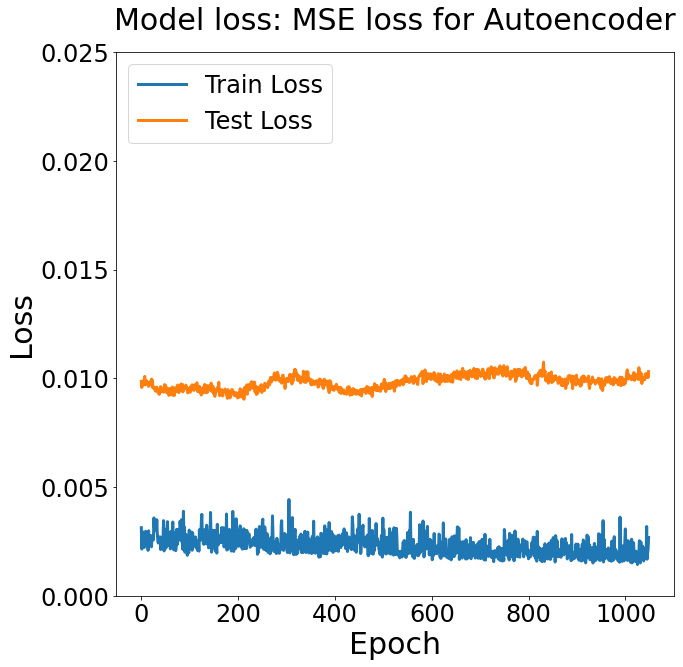

In [35]:
plt.figure(figsize=(10,10))
plt.plot(train_loss, linewidth=3.0)
plt.plot(test_loss, linewidth=3.0)
plt.title('Model loss: MSE loss for Autoencoder',fontsize=30,y=1.03)
plt.ylim(0,0.025)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Loss',fontsize=30)
plt.xlabel('Epoch',fontsize=30)
plt.legend(['Train Loss', 'Test Loss'], loc='upper left',fontsize=24)
plt.savefig('Loss_plot')

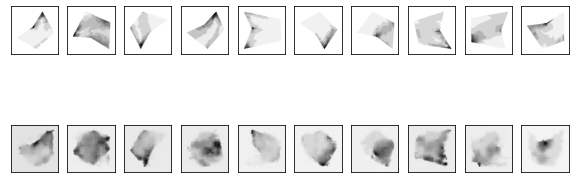

In [34]:
with torch.no_grad():
    for data in test_loader:
        encoded = model.encode(data.x, data.edge_index, data.batch)
        reconstruction = model.decode(encoded)
        break
with torch.no_grad():
    for batch_images in test_images_loader:
        batch_images = batch_images
        break

with torch.no_grad():
    number = 10
    plt.figure(figsize=(10, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(batch_images[index].numpy().reshape(150, 150, 1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(150, 150, 1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

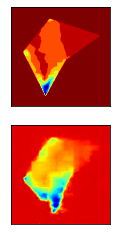

In [37]:
with torch.no_grad():
    for data in test_loader:
        encoded = model.encode(data.x, data.edge_index, data.batch)
        reconstruction = model.decode(encoded)
        break
with torch.no_grad():
    for batch_images in test_images_loader:
        batch_images = batch_images
        break

with torch.no_grad():
    number = 1
    plt.figure(figsize=(10, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(batch_images[index+2].numpy().reshape(150, 150, 1),cmap='jet')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index+2].numpy().reshape(150, 150, 1),cmap='jet')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

print(f'Number of training batches created: {len(train_loader)}')

def test(loader):
    classifier.eval()
    correct = 0
    for data in loader:
        out = autoenencoder.encoder(data.x, data.edge_index, data.batch)
#         print(out)
        out = classifier(out)
        print(out)
        pred = out.argmax(dim=1)
        correct+= int((pred == data.y).sum())
    return correct/len(loader.dataset)


test_acc = test(test_loader)
print(f'Test acc: {test_acc:.4f}')